## Calibration of a line to data comparing approaches to dealing with systematic error

In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict

import corner
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

## define parameters

In [3]:
params = [
    rxmc.params.Parameter("b", float, "y-units"),
    rxmc.params.Parameter("m", float, "no-units"),
]

## make the model

In [4]:
class LinearModel(rxmc.model.Model):
    def __call__(self, params: OrderedDict):
        return params["m"] * self.x + params["b"]

In [5]:
x = np.linspace(0, 1, 10)

In [6]:
my_model = LinearModel(x)

## define a prior

In [7]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)

In [8]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))

In [9]:
n_prior_samples = 100000
prior_distribution = stats.multivariate_normal(mean, covariance)
prior_samples = prior_distribution.rvs(size=n_prior_samples)

In [10]:
y = np.zeros((n_prior_samples, len(my_model.x)))
for i in range(n_prior_samples):
    sample = prior_samples[i, :]
    y[i, :] = my_model(rxmc.params.to_ordered_dict(sample, [p.name for p in params]))

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'prior')

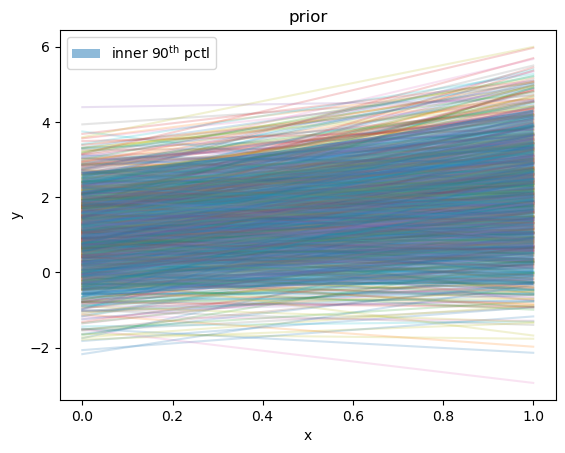

In [11]:
for i in np.random.choice(n_prior_samples, 1000):
    plt.plot(my_model.x, y[i, :], zorder=1, alpha=0.2)
    # pass

plt.fill_between(
    my_model.x, lower, upper, alpha=0.5, zorder=2, label=r"inner 90$^\text{th}$ pctl"
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("prior")

Text(0.5, 0.98, 'prior')

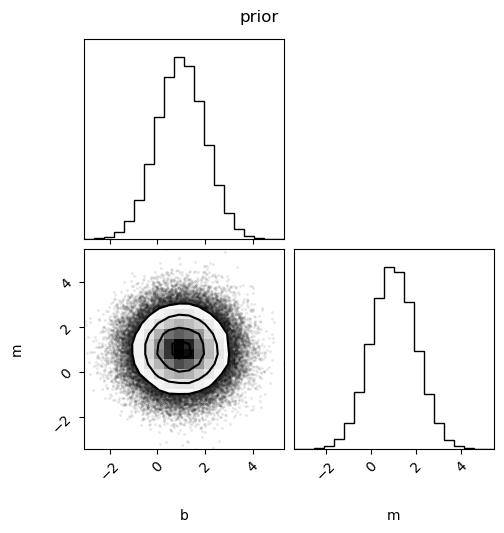

In [12]:
fig = corner.corner(prior_samples, labels=[p.name for p in params])
fig.suptitle("prior")

## find some data
In our case we will synthetically generate some data with noise about a "true" `m` and `b`. Our calibration posterior should converge to be centered about this true point.

Let us assume that the experimentalists made a perfect estimate of the experimental noise in their setup. That is, the error bars they report will correspond exactly to the true distribution from which we sample.

This noise will correspond to statistical noise. Later on we will look at systematic experimental error.

In [13]:
rng = np.random.default_rng(13)

Text(0.5, 1.0, 'experimental constraint')

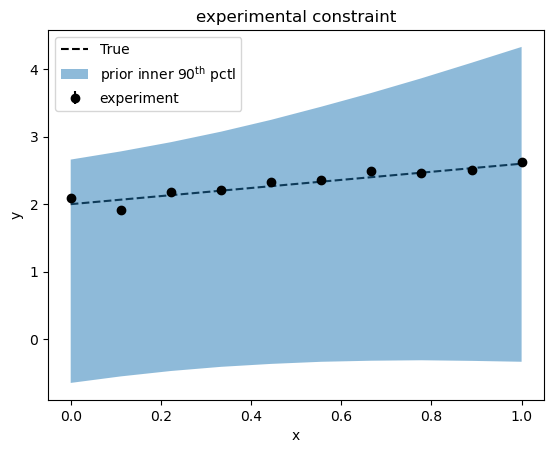

In [14]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

noise = 0.05
y_exp = my_model(true_params) + rng.normal(scale=noise, size=len(my_model.x))
y_exp_err = noise * np.ones_like(y_exp)  # noise is just a constant fraction of y
plt.errorbar(
    my_model.x,
    y_exp,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")

plt.fill_between(
    my_model.x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"prior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("experimental constraint")

## set up constraint

In [15]:
constraint = rxmc.constraint.FixedCovarianceConstraint(
    y_exp,
    np.diag(y_exp_err**2),
    my_model,
)

## running the calibration

First we need to make a Corpus. With one constraint this seems trivial, but this will be useful down the road when we may want to combine multiple constraints together.

In [16]:
corpus = rxmc.corpus.Corpus(
    [constraint],
    [p.name for p in params],
    "my_linear_model",
    "my_experimental_constraint",
)

In [17]:
%%time
# run a single chain
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution, corpus, nsteps=10000, burnin=1000, verbose=True
)

Rank: 0. Burn-in batch 1/1 completed, 1000 steps.
Rank: 0. Batch: 1/1 completed, 9000 steps. Acceptance frac: 0.111
CPU times: user 2.3 s, sys: 7.27 ms, total: 2.3 s
Wall time: 2.31 s


Text(0.5, 0, '$i$')

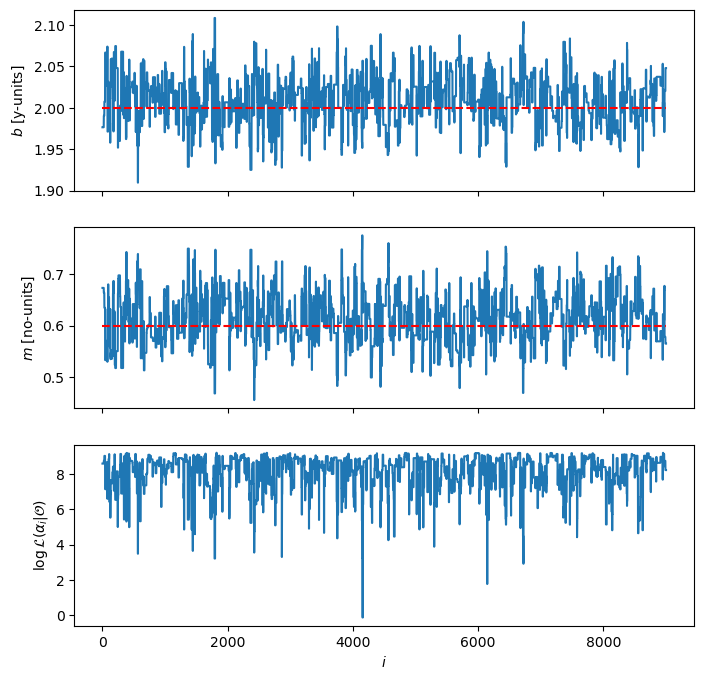

In [18]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${params[i].latex_name}$ [{params[i].unit}]")
    true_value = true_params[params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

In [19]:
posterior_range = np.vstack([np.min(chain, axis=0), np.max(chain, axis=0)]).T

In [20]:
true_params.values()

odict_values([0.6, 2])

Text(0.5, 0.98, 'posterior')

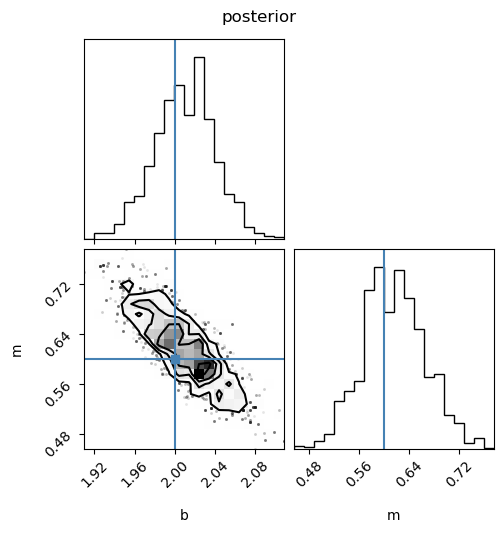

In [21]:
fig = corner.corner(
    chain,
    labels=[p.name for p in params],
    label="posterior",
    truths=[true_params["b"], true_params["m"]],
)
fig.suptitle("posterior")

In [22]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(my_model.x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model(rxmc.params.to_ordered_dict(sample, [p.name for p in params]))

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'predictive posterior')

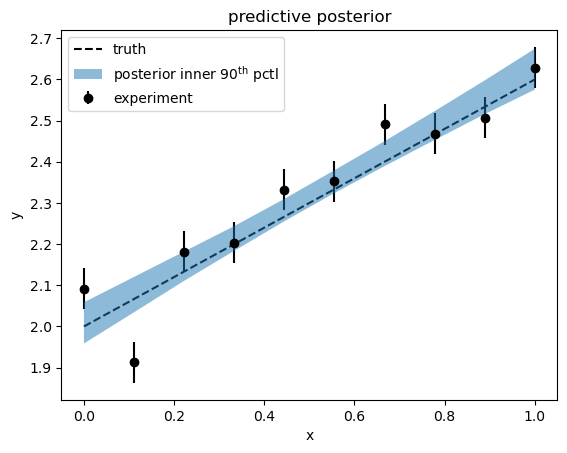

In [23]:
plt.plot(my_model.x, my_model(true_params), "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(
    my_model.x,
    y_exp,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.fill_between(
    my_model.x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("predictive posterior")

True applications should run multiple chains with different random seeds and starting locations to avoid autocorrelation within a chain.

## Handling systematic bias

Now let's imagine we're in a situation where, in addition to the statistical noise reported by the experimenters, we also have a systematic bias reported as a constant fraction of the data. The systematic error reported will correspond to the standard deviation of a new random variable that is the difference of the normalization of the experimental error from 1. 

1.021605343066887


Text(0.5, 1.0, 'experimental constraint with bias')

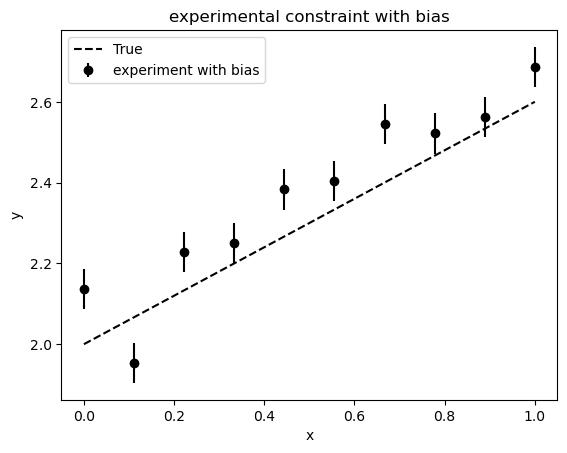

In [24]:
systematic_fractional_err = 0.05
normalization = 1 + rng.normal(scale=systematic_fractional_err)
print(normalization)
y_exp_with_sys = y_exp * normalization
plt.errorbar(
    my_model.x,
    y_exp_with_sys,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("experimental constraint with bias")

### Attempt 1: Use the same covariance matrix as before
This is effectively ignoring the systematic error

In [25]:
constraint = rxmc.constraint.FixedCovarianceConstraint(
    y_exp_with_sys,
    np.diag(y_exp_err**2),
    my_model,
)

In [26]:
corpus_sys_err = rxmc.corpus.Corpus(
    [constraint],
    [p.name for p in params],
    "my_linear_model",
    "constraint_with_biased_data",
)

In [27]:
%%time
# run a single chain
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution, corpus_sys_err, nsteps=20000, burnin=1000, verbose=True
)

Rank: 0. Burn-in batch 1/1 completed, 1000 steps.
Rank: 0. Batch: 1/1 completed, 19000 steps. Acceptance frac: 0.110
CPU times: user 4.38 s, sys: 5.29 ms, total: 4.38 s
Wall time: 4.38 s


Text(0.5, 0, '$i$')

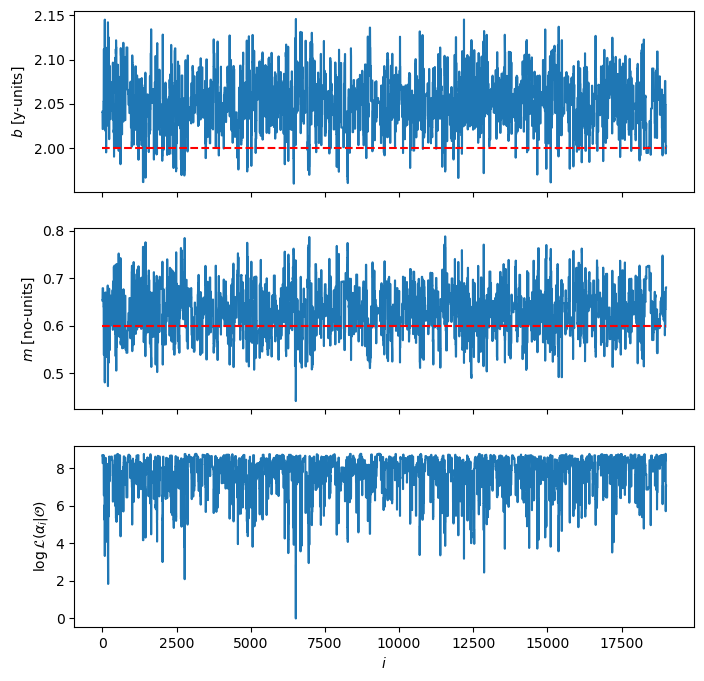

In [28]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${params[i].latex_name}$ [{params[i].unit}]")
    true_value = true_params[params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

Text(0.5, 0.98, 'posterior')

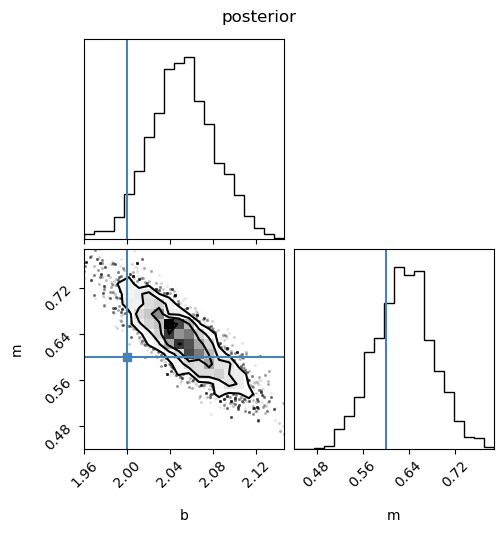

In [29]:
fig = corner.corner(
    chain,
    labels=[p.name for p in params],
    label="posterior",
    truths=[true_params["b"], true_params["m"]],
)
fig.suptitle("posterior")

In [30]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(my_model.x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model(rxmc.params.to_ordered_dict(sample, [p.name for p in params]))

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'predictive posterior')

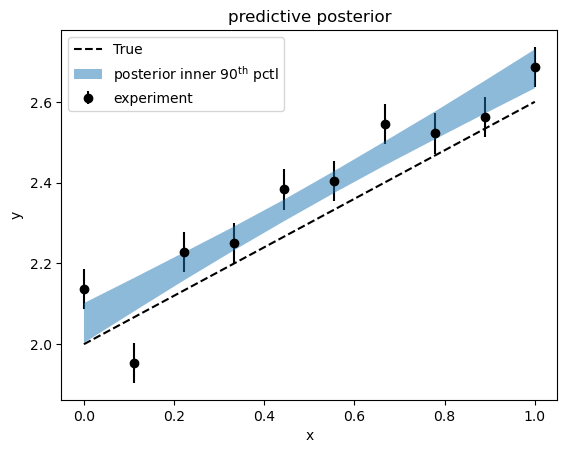

In [31]:
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(
    my_model.x,
    y_exp_with_sys,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.fill_between(
    my_model.x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("predictive posterior")

Ok, we can fit to the data well, but we've completely ignored the bias between the data and the truth. Let's try something else:

### Attempt 2: adjust our covariance matrix to include the correlations due to systematic bias

In this case, we will again use a `FixedCovarianceConstraint`, but we will now include off-diagonal terms due the reported bias, following [Barlow, 2020](https://www.sciencedirect.com/science/article/pii/S0168900220312614).

In [32]:
covariance = np.diag(y_exp_err**2) + systematic_fractional_err**2 * np.outer(
    y_exp_with_sys, y_exp_with_sys
)

In [33]:
constraint = rxmc.constraint.FixedCovarianceConstraint(
    y_exp_with_sys, covariance, my_model
)

In [34]:
corpus_sys_err = rxmc.corpus.Corpus(
    [constraint],
    [p.name for p in params],
    "my_linear_model",
    "constraint_with_bias",
)

In [35]:
%%time
# run a single chain
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution, corpus_sys_err, nsteps=20000, burnin=1000, verbose=True
)

Rank: 0. Burn-in batch 1/1 completed, 1000 steps.
Rank: 0. Batch: 1/1 completed, 19000 steps. Acceptance frac: 0.431
CPU times: user 4.54 s, sys: 1.31 ms, total: 4.54 s
Wall time: 4.54 s


Text(0.5, 0, '$i$')

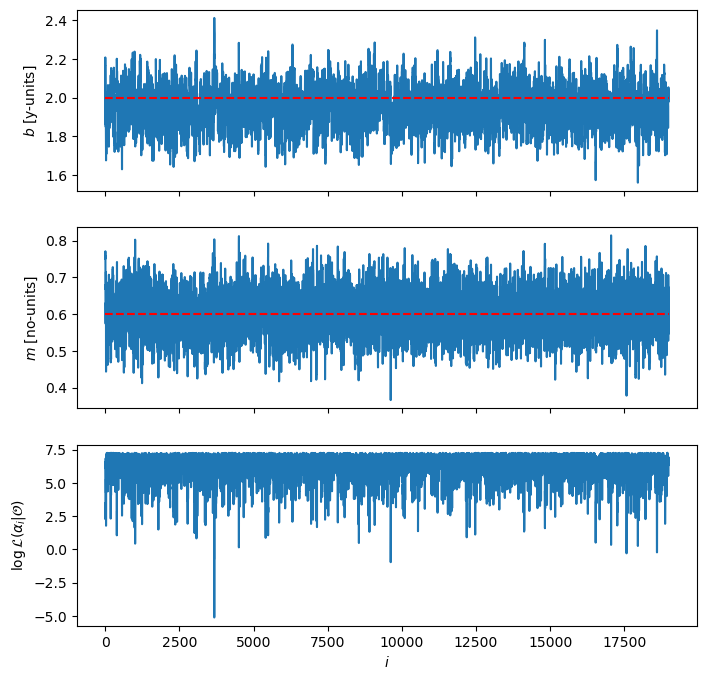

In [36]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${params[i].latex_name}$ [{params[i].unit}]")
    true_value = true_params[params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

Text(0.5, 0.98, 'posterior')

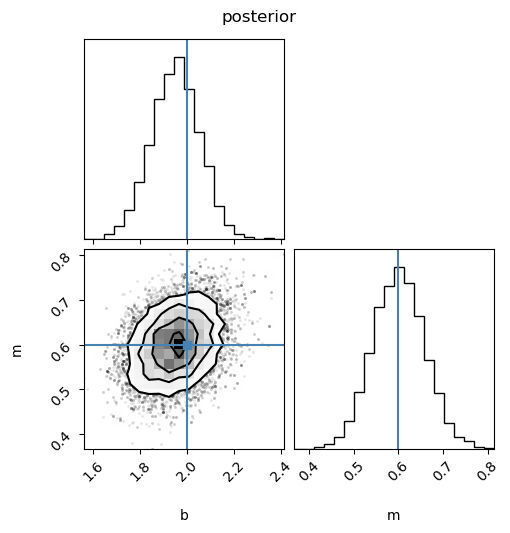

In [37]:
fig = corner.corner(
    chain,
    labels=[p.name for p in params],
    label="posterior",
    truths=[true_params["b"], true_params["m"]],
)
fig.suptitle("posterior")

In [38]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(my_model.x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model(rxmc.params.to_ordered_dict(sample, [p.name for p in params]))

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'predictive posterior')

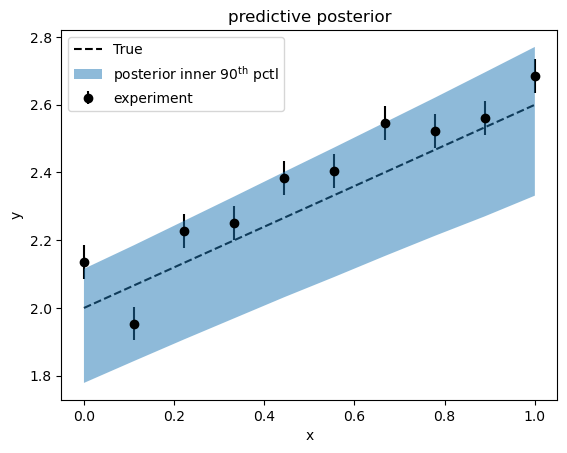

In [39]:
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(
    my_model.x,
    y_exp_with_sys,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.fill_between(
    my_model.x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("predictive posterior")

This doesn't look bad... 

Just to check, let's see hat happens if we choose a case in which the experimental data is normalized to a smaller value than the truth?

Text(0.5, 1.0, 'experimental constraint with negative bias')

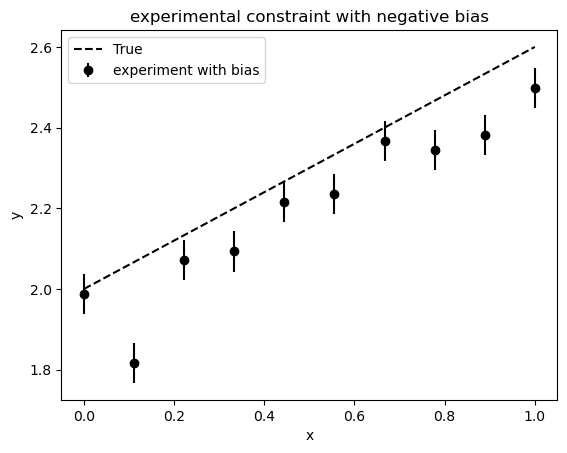

In [40]:
normalization = 1 - systematic_fractional_err
y_exp_neg_bias = y_exp * normalization
plt.errorbar(
    my_model.x,
    y_exp_neg_bias,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("experimental constraint with negative bias")

In [41]:
constraint = rxmc.constraint.FixedCovarianceConstraint(
    y_exp_neg_bias,
    np.diag(y_exp_err**2)
    + systematic_fractional_err**2 * np.outer(y_exp_neg_bias, y_exp_neg_bias),
    my_model,
)

In [42]:
corpus_sys_err = rxmc.corpus.Corpus(
    [constraint],
    [p.name for p in params],
    "my_linear_model",
    "constraint_with_bias",
)

In [43]:
%%time
# run a single chain
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution, corpus_sys_err, nsteps=20000, burnin=1000, verbose=True
)

Rank: 0. Burn-in batch 1/1 completed, 1000 steps.
Rank: 0. Batch: 1/1 completed, 19000 steps. Acceptance frac: 0.422
CPU times: user 4.43 s, sys: 1.14 ms, total: 4.43 s
Wall time: 4.43 s


Text(0.5, 0, '$i$')

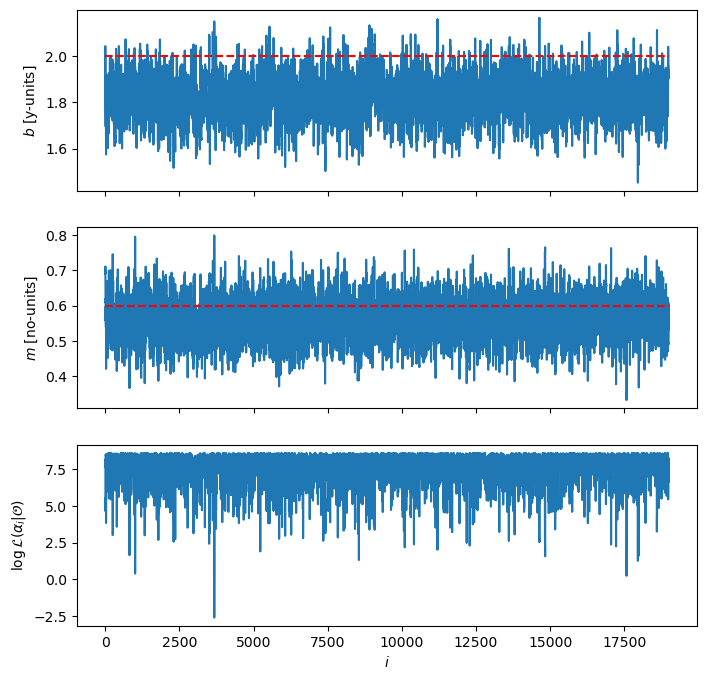

In [44]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${params[i].latex_name}$ [{params[i].unit}]")
    true_value = true_params[params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

Text(0.5, 0.98, 'posterior')

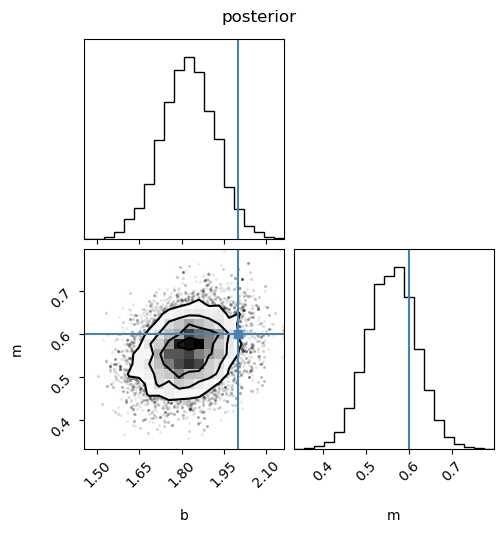

In [45]:
fig = corner.corner(
    chain,
    labels=[p.name for p in params],
    label="posterior",
    truths=[true_params["b"], true_params["m"]],
)
fig.suptitle("posterior")

In [46]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(my_model.x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model(rxmc.params.to_ordered_dict(sample, [p.name for p in params]))

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'predictive posterior')

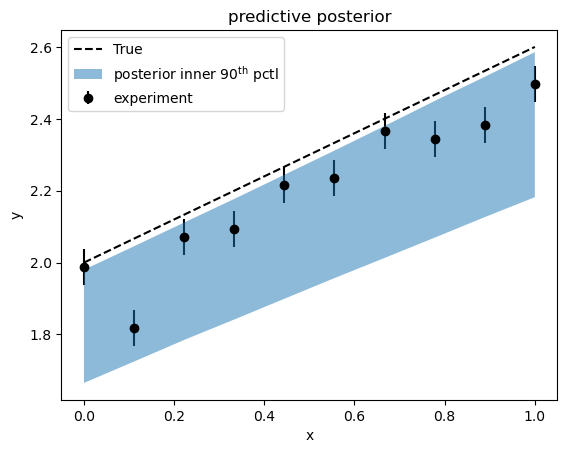

In [47]:
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(
    my_model.x,
    y_exp_neg_bias,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.fill_between(
    my_model.x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("predictive posterior")

Wow, this sucks! What gives?

### Attempt 3: proper covariance matrix

The truth is that we have incorrectly defined the covariance matrix, which leads to the maximum-likelihood region to always be shifted to smaller $y$. See [D'Agostini, 1993](https://s3.cern.ch/inspire-prod-files-a/af06df9041f5b73dcdf6d1ae8172caa1). 

So how do we fix it? The answer is we need a **parameter-dependent** likelihood model, in which the magnitude of the covariance is $\sigma^2_{ij} = \sigma_{\text{stat}}^2 \delta_{ij} + \sigma_{\text{sys}}^2 f(x_i, \alpha) f(x_j, \alpha)$, where $f(x_i,\alpha)$ is now the model value, replacing the experimental value $y_{i}$. It is dependent on the parameter values $\alpha$. 

To do this with `rxmc`, we can't use `FixedCovarianceConstraint` anymore, as the covariance is now dependent on the parameters of the model. We can instead use the class `ConstraintWithKnownError`, as both the statistical and systematic uncertainties are reported (and we will not (yet) attempt to include them as parameters and calibrate them as well).

In [48]:
constraint = rxmc.constraint.ConstraintWithKnownError(
    y_exp_neg_bias,
    my_model,
    sys_err_frac=systematic_fractional_err,
    diag_err_frac=0,
    model_independent_covariance=np.diag(y_exp_neg_bias**2),
)
corpus_sys_err = rxmc.corpus.Corpus(
    [constraint],
    [p.name for p in params],
    "my_linear_model",
    "constraint_with_bias_and_correct_covariance",
)

In [49]:
%%time
# run a single chain
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution, corpus_sys_err, nsteps=20000, burnin=1000, verbose=True
)

Rank: 0. Burn-in batch 1/1 completed, 1000 steps.
Rank: 0. Batch: 1/1 completed, 19000 steps. Acceptance frac: 0.920
CPU times: user 5.79 s, sys: 3.11 ms, total: 5.79 s
Wall time: 5.79 s


Text(0.5, 0, '$i$')

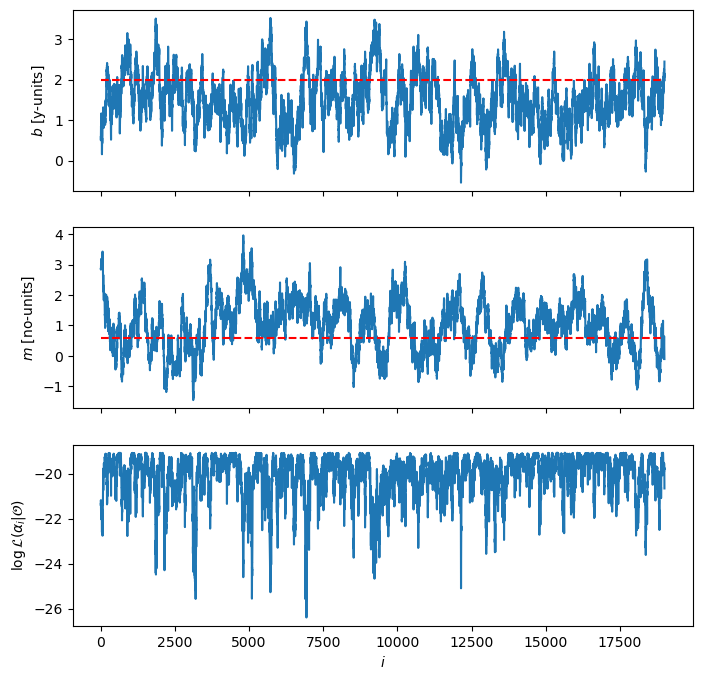

In [50]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${params[i].latex_name}$ [{params[i].unit}]")
    true_value = true_params[params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

Text(0.5, 0.98, 'posterior')

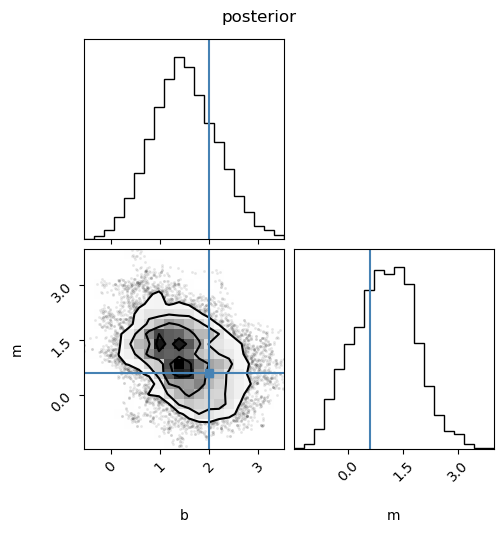

In [51]:
fig = corner.corner(
    chain,
    labels=[p.name for p in params],
    label="posterior",
    truths=[true_params["b"], true_params["m"]],
)
fig.suptitle("posterior")

In [52]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(my_model.x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model(rxmc.params.to_ordered_dict(sample, [p.name for p in params]))

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'predictive posterior')

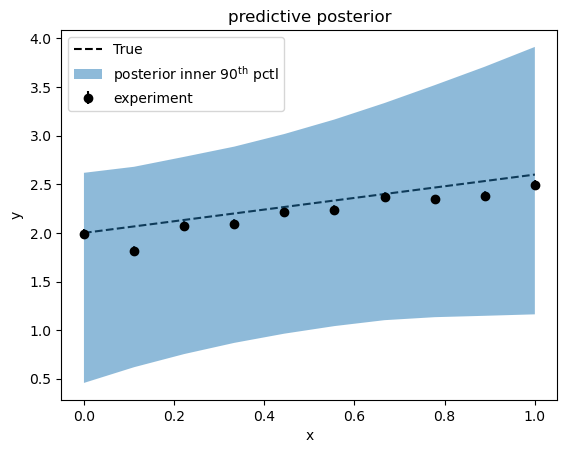

In [53]:
plt.plot(my_model.x, my_model(true_params), "k--", label=True)
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(
    my_model.x,
    y_exp_neg_bias,
    y_exp_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.fill_between(
    my_model.x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("predictive posterior")

Alright! It looks like it's not so bad, but there is an extra-large uncertainty reflecting the fact that we are unsure about our bias.

## What if we have multiple constraints?

Now let's imagine that there are two experimental groups, who have both reported some data with statistical and systematic errors.

In [72]:
systematic_fractional_err_2 = 0.05
noise2 = 0.05
x2 = np.linspace(0.6, 1.5, 30)
model2 = LinearModel(x2)
y_exp_2 = model2(true_params) + rng.normal(scale=noise2, size=len(model2.x))
normalization = 1.0 - systematic_fractional_err_2
y_exp_err2 = noise2 * np.ones_like(y_exp_2)
y_exp_with_sys_2 = y_exp_2 * normalization

In [73]:
corpus = rxmc.corpus.Corpus(
    [
        rxmc.constraint.ConstraintWithKnownError(
            y_exp_neg_bias,
            my_model,
            sys_err_frac=systematic_fractional_err,
            diag_err_frac=0,
            model_independent_covariance=np.diag(y_exp_err**2),
        ),
        rxmc.constraint.ConstraintWithKnownError(
            y_exp_with_sys_2,
            model2,
            sys_err_frac=systematic_fractional_err_2,
            diag_err_frac=0,
            model_independent_covariance=np.diag(y_exp_err2**2),
        ),
    ],
    [p.name for p in params],
    "my_linear_model",
    "multiple_constraints",
)

Text(0.5, 1.0, 'multiple experimental constraint with bias')

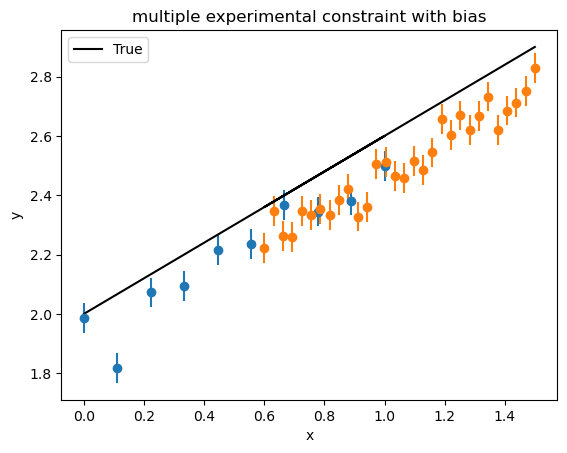

In [74]:
x = corpus.x
for constraint in corpus.constraints:
    plt.errorbar(
        constraint.model.x,
        constraint.y,
        np.diag(np.sqrt(constraint.model_independent_covariance)),
        marker="o",
        linestyle="none",
    )
plt.plot(x, LinearModel(x)(true_params), "k", label=True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("multiple experimental constraint with bias")

In [75]:
%%time
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution, corpus, nsteps=20000, burnin=1000, verbose=True
)

Rank: 0. Burn-in batch 1/1 completed, 1000 steps.
Rank: 0. Batch: 1/1 completed, 19000 steps. Acceptance frac: 0.169
CPU times: user 7.37 s, sys: 1.07 ms, total: 7.37 s
Wall time: 7.37 s


Text(0.5, 0, '$i$')

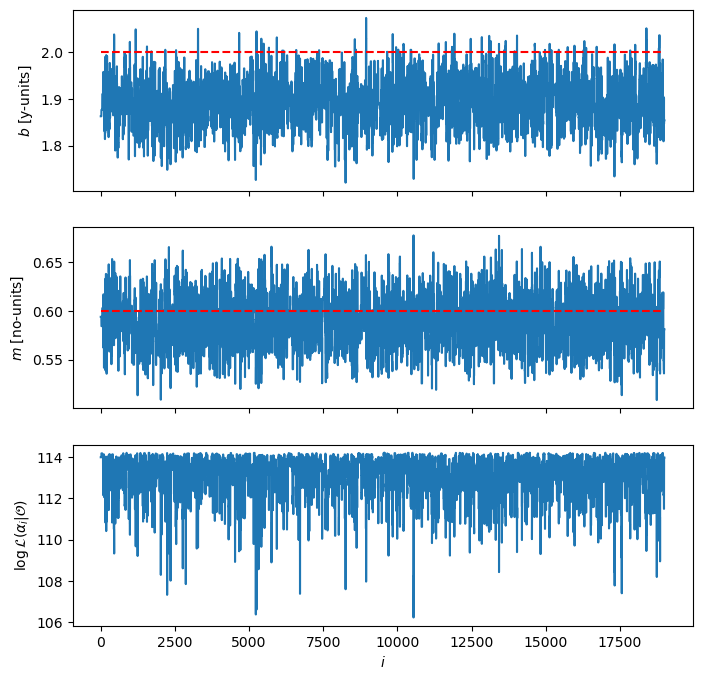

In [76]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${params[i].latex_name}$ [{params[i].unit}]")
    true_value = true_params[params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

Text(0.5, 0.98, 'posterior')

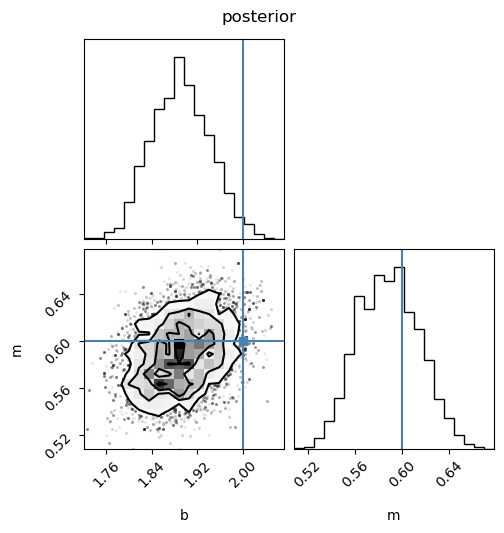

In [77]:
fig = corner.corner(
    chain,
    labels=[p.name for p in params],
    label="posterior",
    truths=[true_params["b"], true_params["m"]],
)
fig.suptitle("posterior")

In [78]:
n_posterior_samples = chain.shape[0]
x = corpus.x

y = np.zeros((n_posterior_samples, len(x)))

for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = LinearModel(x)(
        rxmc.params.to_ordered_dict(sample, [p.name for p in params])
    )

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'predictive posterior - multiple constraints with similar biases')

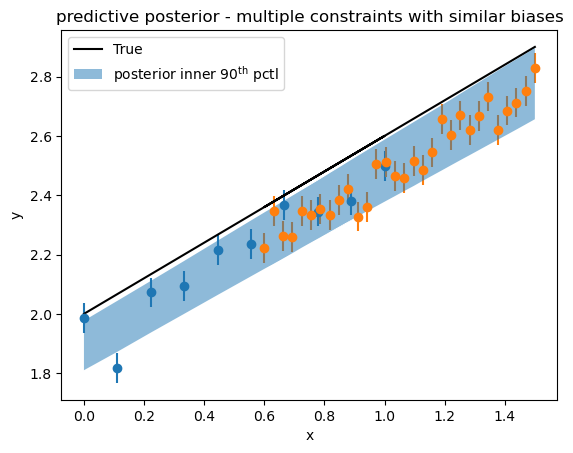

In [79]:
for constraint in corpus.constraints:
    plt.errorbar(
        constraint.model.x,
        constraint.y,
        np.diag(np.sqrt(constraint.model_independent_covariance)),
        marker="o",
        linestyle="none",
    )
plt.plot(x, LinearModel(x)(true_params), "k", label=True)
plt.xlabel("x")
plt.ylabel("y")

plt.fill_between(
    x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("predictive posterior - multiple constraints with similar biases")

What if they're biased in different directions?

In [83]:
y_exp_2 = model2(true_params) + rng.normal(scale=noise2, size=len(model2.x))
normalization = 1 + systematic_fractional_err_2
y_exp_with_sys_2 = y_exp_2 * normalization

In [86]:
corpus = rxmc.corpus.Corpus(
    [
        rxmc.constraint.ConstraintWithKnownError(
            y_exp_neg_bias,
            my_model,
            sys_err_frac=systematic_fractional_err,
            diag_err_frac=0,
            model_independent_covariance=np.diag(y_exp_err**2),
        ),
        rxmc.constraint.ConstraintWithKnownError(
            y_exp_with_sys_2,
            model2,
            sys_err_frac=systematic_fractional_err_2,
            diag_err_frac=0,
            model_independent_covariance=np.diag(y_exp_err2**2),
        ),
    ],
    [p.name for p in params],
    "my_linear_model",
    "multiple_constraints",
)

Text(0.5, 1.0, 'multiple experimental constraint with different biases')

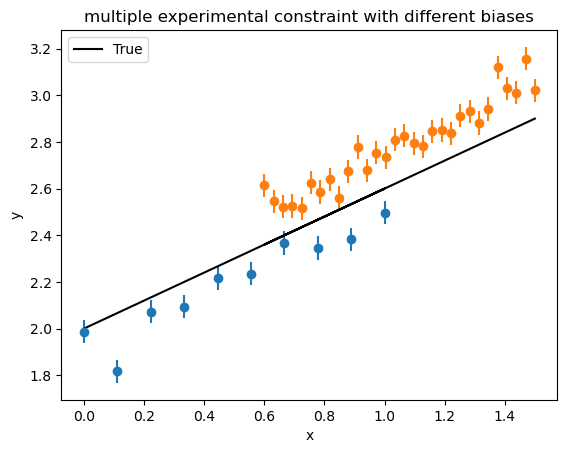

In [87]:
x = corpus.x
for constraint in corpus.constraints:
    plt.errorbar(
        constraint.model.x,
        constraint.y,
        np.diag(np.sqrt(constraint.model_independent_covariance)),
        marker="o",
        linestyle="none",
    )
plt.plot(x, LinearModel(x)(true_params), "k", label=True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("multiple experimental constraint with different biases")

In [88]:
%%time
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution, corpus, nsteps=20000, burnin=1000, verbose=True
)

Rank: 0. Burn-in batch 1/1 completed, 1000 steps.
Rank: 0. Batch: 1/1 completed, 19000 steps. Acceptance frac: 0.172
CPU times: user 7.33 s, sys: 2.01 ms, total: 7.34 s
Wall time: 7.34 s


Text(0.5, 0, '$i$')

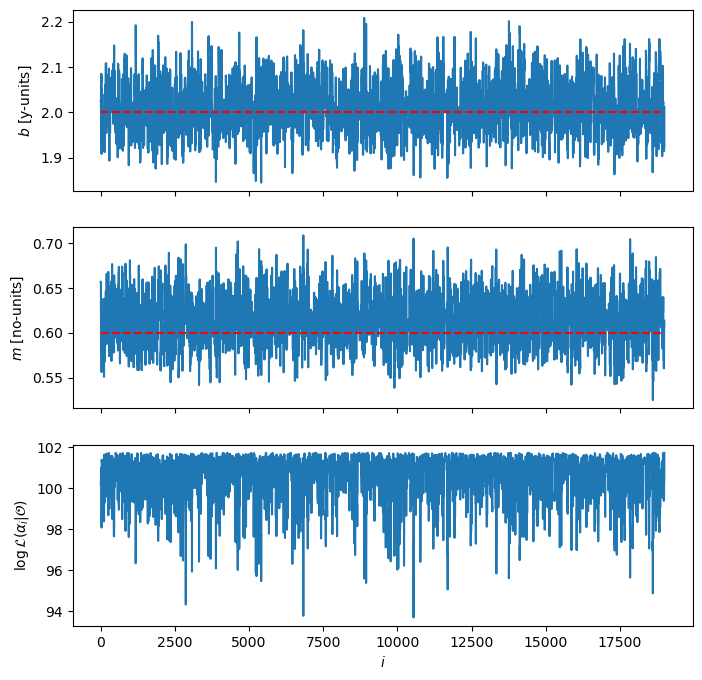

In [89]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${params[i].latex_name}$ [{params[i].unit}]")
    true_value = true_params[params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

Text(0.5, 0.98, 'posterior')

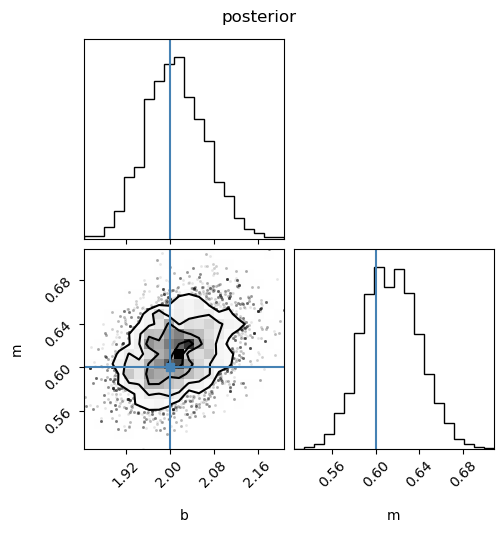

In [90]:
fig = corner.corner(
    chain,
    labels=[p.name for p in params],
    label="posterior",
    truths=[true_params["b"], true_params["m"]],
)
fig.suptitle("posterior")

In [91]:
n_posterior_samples = chain.shape[0]
x = corpus.x

y = np.zeros((n_posterior_samples, len(x)))

for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = LinearModel(x)(
        rxmc.params.to_ordered_dict(sample, [p.name for p in params])
    )

upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'predictive posterior - multiple constraints with opposite biases')

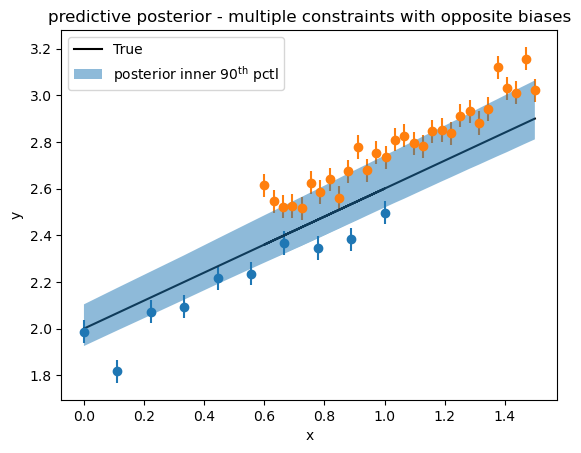

In [92]:
for constraint in corpus.constraints:
    plt.errorbar(
        constraint.model.x,
        constraint.y,
        np.diag(np.sqrt(constraint.model_independent_covariance)),
        marker="o",
        linestyle="none",
    )
plt.plot(x, LinearModel(x)(true_params), "k", label=True)
plt.xlabel("x")
plt.ylabel("y")

plt.fill_between(
    x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("predictive posterior - multiple constraints with opposite biases")

## Interesting!

In general, for any model, if one only has a few experiments covering different parts of the domain, $x$, the different biases ***may*** end up affecting the posterior for certain parameters in the model. Even though those experiments are in reality ***perfectly independent***, a false $x$ dependence in the corpus is possible do to biases aligning by random chance, due to the fact that there are only a few independent experiments.

In general, we can expect that is is only in the limit of 1) small bias relative to statistical error, or 2) many experiments with independent biases, that we can actually approach the true value. This is because each experiment effective provides only a single data point on the overall normalization.

# TODO
- clean up and add tests
- compare right and wrong likelihood models on same plot for multi constraint example
- compare multi constraints when noise is very small relative to bias - does this affect the marginal posterior for $m$?

In [70]:
x0 = rxmc.params.to_ordered_dict(prior_distribution.mean, [p.name for p in params])
constraint.chi2(x0) / constraint.n_data_pts

np.float64(31.231249431500796)

In [71]:
ym = constraint.model(x0)
chi2, log = rxmc.constraint.mahalanobis_distance_cholesky(
    constraint.y, ym, constraint.covariance
)
chi2 / constraint.n_data_pts

AttributeError: 'ConstraintWithKnownError' object has no attribute 'covariance'

In [ ]:
constraint.log_det

In [ ]:
log